In [14]:
import keras
import math
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Activation
from keras.layers import Dense, Flatten
from keras.layers import Convolution2D
from keras.layers import MaxPooling2D
from keras.utils import np_utils
from keras.optimizers import SGD, RMSprop
from matplotlib import pyplot as plt
import tensorflow as tf
import numpy as np


trainEpochs = 1
batchSize = 32
sess = tf.Session() #get backend tensorflow session
keras.backend.set_session(sess) #connect keras session with tensorflow session

(x_train, y_train), (x_test, y_test) = mnist.load_data() #fetch mnist data online...
x_test_orig = x_test[:] #save an original copy of test data (for later comparison to adv examples)

#tensorflow expects explicit channel dimension so we add it here to be (28x28x1)
x_train = x_train.reshape(x_train.shape[0], 28, 28, 1)
x_test = x_test.reshape(x_test.shape[0], 28, 28, 1) #note this is why we saved x_test_orig for later

#as floats
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

#between 0 and 1
x_train /= 255
x_test /= 255

#categorical classes (vectors of 1x10, one-hot)
#so a class of 0 would be: 1000000000; and 4 would be: 0000100000 (note index is 0-based)
y_train = np_utils.to_categorical(y_train, 10)
y_test = np_utils.to_categorical(y_test, 10)

#create model
#model = Sequential() #sequential model: A->B->Out
#Conv layer 32 input, 3 by 3 convolution, relu activation
#model.add(Convolution2D(32, (3, 3), activation = 'relu', input_shape = (28, 28, 1)))
#model.add(Flatten()) #flatten the 2d output of the conv layer to a vector
#fully connected; output a 1x10 vector, each value is interpreted as a prob of it being that class
#note softmax used bc it normlizes output such that the outputs sum to 1
#model.add(Dense(10, activation = 'softmax'))

#compile model
#model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
#print("Training... (train loss and acc shown as model is updated)")
#fit model to training data
#model.fit(x_train, y_train, batch_size = batchSize, epochs = trainEpochs, verbose = 1)
#evaluate model against test data
#score = model.evaluate(x_test, y_test, verbose = 0)
#print("Test accuracy on normal examples: " + str(score[1]))

model3 = Sequential()
model3.add(Convolution2D(20, 5, 5, border_mode="same",input_shape=(28,28,1)))
model3.add(Activation("relu"))
model3.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

# second set of convolutional => rectifier => pooling
model3.add(Convolution2D(50, 5, 5, border_mode="same"))
model3.add(Activation("relu"))
model3.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

# set of full => rectifier layers
model3.add(Flatten())
model3.add(Dense(500))
model3.add(Activation("relu"))

# softmax classifier
model3.add(Dense(10))
model3.add(Activation("softmax"))

model3.compile(loss='categorical_crossentropy', optimizer=RMSprop(), metrics=["accuracy"])
model3.fit(x_train, y_train, batch_size=batchSize, epochs=trainEpochs, verbose=1)
#evaluate model against test data
score = model3.evaluate(x_test, y_test, verbose = 0)
print("Test accuracy on normal examples: " + str(score[1]))

##set to training mode (fixes issue with Dropout in network so we don't have to pass values for Dropout)
#keras.backend.set_learning_phase(1)

#perform adversarial adjustment using fast gradient method
#note: we just get the loss between a real example and its target, then
#instead of adjusting weights in the opposite direction as we would in backprop,
#we take the gradients of the loss with respect to the input and adjust the input
#in that same direction (eg, toward higher loss). Fast gradient actually just takes 
#the sign of each gradient (+1 or -1), then adjusts the input by eps amount in that direction.
#Note the direction we go in is always going toward more loss. If +1 at some input point, then  
#as that input goes up, so does loss, we add eps * +1 to get more loss. If -1 at some input point,
#then loss goes down with that input, so we decrease that input value to get more loss. 
def fastGradientMethod(model, x, eps=0.01, epochs=1, clip_min=0., clip_max=1.):
    x_adv = tf.identity(x) #copy of x, all the test examples
    #current pred classes (remember it is 1x10, so this is a prob dist) and it is per example
    ybar = model(x_adv) 
    yshape = ybar.get_shape().as_list()
    ydim = yshape[1]
    #get index of highest prob (eg the single predicted class)
    #note the name is plural (indices) bc it is each index for every example, so it is a list of indexes
    #per example
    indices = tf.argmax(ybar, axis=1) 
    #target is one-hot vector with that class at 1 (again, per example so plural name)
    targets = tf.one_hot(indices, ydim, on_value=1.0, off_value=0.0) 
    #loss function is loss between ybar (prob dist) and one-hot vector with pred class as 1
    loss_fn = tf.nn.softmax_cross_entropy_with_logits 
    
    #just used by tensorflow to stop looping over epochs
    def _cond(x_adv, i):
        return tf.less(i, epochs)
    
    #body of while loop over epochs
    def _body(x_adv, i):
        #get model pred of class and logits (log (p/1-p) for each possible class)
        ybar, logits = model(x_adv, logits=True)
        #get losses between one-hot targets and logits
        losses = loss_fn(labels=targets, logits=logits)
        #get gradients between losses and (non-adjusted) examples
        dy_dxs, = tf.gradients(losses, x_adv)
        #adjust examples to get adversarial examples!
        #add the sign of each gradient (+1 or -1) times the eps step value, eg 0.3 to the example
        #to increase loss
        x_adv = tf.stop_gradient(x_adv + eps*tf.sign(dy_dxs))
        #clip input values to be between 0 and 1
        x_adv = tf.clip_by_value(x_adv, clip_min, clip_max)
        #return the example and an incremented epoch
        return x_adv, i+1

    #get adv examples by looping for X epochs (just 1 for our purposes)
    #note 'name' is just the name of this step in the network, has no special meaning
    #(x_adv, 0) are just params for _cond and _body per loop
    #and back_prop is false bc we are doing no learning here, just adj inputs
    x_adv, _ = tf.while_loop(_cond, _body, (x_adv, 0), back_prop=False, name='fgsm')
    return x_adv

#placeholders for x and y, we feed then with feed_dict later when we run the adv code
x = tf.placeholder(tf.float32, shape=(None, 28, 28, 1))
y = tf.placeholder(tf.float32, shape=(None, 10))

#fn to return predicted classes as dist with or without logits
def _model_fn(x, logits=False):
    ybar = model3(x)
    logits_, = ybar.op.inputs
    if logits:
        return ybar, logits_
    return ybar

#get adv examples
#note we feed x in as a placeholder for x data. This is bc tensorflow models only 
#compile models for later running. So we have no data right now and x_adv is just a model
#that is compiled and *can* be run or evaluated with a feed_dict specifying x and y
#So x_adv runs the true model to get predictions, then gradients, so it does need x and y 
#provided when ran below
x_adv = fastGradientMethod(_model_fn, x, 0.3)

#feed dict to feed data to models
feed_dict = {x: x_test[:], y: y_test[:]}
#actually run the x_adv model to get actual adverarial examples
actual_x_adv = sess.run(x_adv, feed_dict=feed_dict)
#resshape them for plotting
actual_x_adv = actual_x_adv.reshape(actual_x_adv.shape[0], 28, 28)

#create normal prediction model 
preds_norm = model3(x)
#create adv prediction model (should have lower acc)
preds_adv = model3(x_adv)

#actually run the two models
actual_norm_preds = sess.run(tf.argmax(preds_norm, axis=-1), feed_dict=feed_dict)
actual_adv_preds = sess.run(tf.argmax(preds_adv, axis=-1), feed_dict=feed_dict)

#get all examples where the normal argmax pred does not equal the adv argmax pred, ie, 
#the ones that we adv successfully tricked! Store a list of the index, i, for this example,
#the normal pred, and the actual pred
y_adv_y = [(i, p, actual_adv_preds[i]) for i, p in enumerate(actual_norm_preds) if p != actual_adv_preds[i]]

/Users/gdcutting/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:60: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(20, (5, 5), input_shape=(28, 28, 1..., padding="same")`
/Users/gdcutting/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:65: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(50, (5, 5), padding="same")`


Epoch 1/1
60000/60000 [==============================] - 149s - loss: 0.1152 - acc: 0.9655      

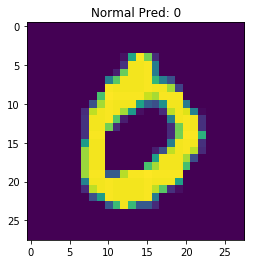

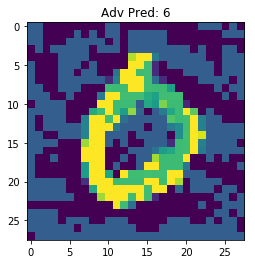

Test accuracy on adversarial examples: 0.1903


In [12]:
from cleverhans.utils_tf import model_train, model_eval

#plot original test data of first successfully tricked example and title with normally predicted class
plt.imshow(x_test_orig[y_adv_y[2][0]])
plt.title("Normal Pred: " + str(y_adv_y[2][1]))
plt.show()

#plot adv test data of first successfully tricked example and title with adv predicted class
plt.imshow(actual_x_adv[y_adv_y[2][0]])
plt.title("Adv Pred: " + str(y_adv_y[2][2]))
plt.show()

#make model to get all of the examples where the correct class equals the pred adv class
correct_preds = tf.equal(tf.argmax(y, axis=-1), tf.argmax(preds_adv, axis=-1))
#make model to get the avg number correct 
#acc_value = tf.reduce_mean(tf.to_float(correct_preds))
#run it
#accuracy = acc_value.eval(feed_dict=feed_dict, session=sess)
#report accuracy on adv examples!
print("Test accuracy on adversarial examples: " + str(accuracy))


eval_params = {'batch_size': 32}

preds_2_adv = model3(x_adv)
accuracy = model_eval(sess, x, y, preds_2_adv, x_train, y_train, args=eval_params)

In [13]:
print(accuracy)

0.188066666667
